_This notebook contains code and comments from Section 5.4 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

## 5.5 Case Study: Document Retrieval
Document retrieval is the task of retrieving documents from a database to match a user’s query. For example, a paralegal at a law firm might need to search for information about previous cases from legal archives in order to establish precedent and research case law. Or perhaps a graduate student might need to search for articles from a journal’s database during the course of a literature survey of work in a specific area. 

In this case study, the problem is set up as a 3-class classification problem of identifying the relevance rank/class (least, moderately or highly relevant) given a query-document pair. We explore the performance of different LightGBM classifiers for this task. 

### 5.5.1	The LETOR Data Set
The data set we will use for this case study is called the LEarning TO Rank (LETOR) ver. 4.0, which was itself created from a large corpus of webpages called GOV2. The [GOV2 data set](http://ir.dcs.gla.ac.uk/test_collections/access_to_data.html) is a collection of about 25 million webpages extracted from the .gov domain.

The LETOR 4.0  data collection is derived from the GOV2 corpus and is made freely available by Microsoft Research. The collection contains several data sets, and we will use the data set that was originally developed for the Million Query track of the 2008 Text Retrieval Conference (TREC), specifically, [MQ2008.rar](https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/#!letor-4-0). 


In [1]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

# Load the data
query_data_file = './data/ch05/MQ2008/Querylevelnorm.txt'
X, y = load_svmlight_file(query_data_file)

# Split into train and test sets
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
print(Xtrn.shape, Xtst.shape)

(12168, 46) (3043, 46)


In [3]:
# LightGBM has numerous parameters that we want to optimize over
import numpy as np
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import time

fixed_params = {'early_stopping_rounds': 25, 
                'eval_metric' : 'multi_logloss', 
                'eval_set' : [(Xtst, ytst)],
                'eval_names': ['test set'],
                'verbose': 100}

num_random_iters = 20
num_cv_folds = 5

cv_scores = {}
tst_scores = {}
run_time = {}

### 5.5.2	Document Retrieval with LightGBM
We will learn four models using LightGBM. Each of these models represents a tradeoff between speed and accuracy:
* random forest: our now familiar parallel homogeneous ensemble of randomized decision trees; this method will serve as a baseline approach;
* gradient boosted decision trees (GBDT): this is the standard approach to gradient boosting and represents a balance between models with good generalization performance and training speed;
* gradient boosting with gradient one-side sampling (GOSS): this variant of gradient boosting downsamples the training data and is ideally suited for large data sets; due to downsampling, it may lose out on generalization, but is typically very fast to train;
* Dropout meets Multiple Additive Regression Trees (DART): this variant incorporates the notion of dropout from deep learning, where neural units are randomly and temporarily dropped during backpropagation iterations to mitigate overfitting. Similarly, DART randomly and temporarily drops base estimators from the overall ensemble during gradient fitting iterations to mitigate overfitting. DART is often the slowest of all the gradient boosting options available in LightGBM.


---
#### Learning with Random Forests

In [4]:
rf_params = {'bagging_fraction': [0.4, 0.5, 0.6, 0.7, 0.8],
             'bagging_freq': [5, 6, 7, 8],
             'num_leaves': randint(5, 50)}

start = time.time()
ens = lgb.LGBMClassifier(boosting='rf', n_estimators=1000, max_depth=-1, metric='multi_logloss', random_state=42)
cv = RandomizedSearchCV(estimator=ens, 
                        param_distributions=rf_params, 
                        n_iter=num_random_iters, 
                        cv=num_cv_folds, 
                        refit=True,
                        random_state=42, verbose=True)

cv.fit(Xtrn, ytrn, **fixed_params)
run_time['rf'] = time.time() - start

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training until validation scores don't improve for 25 rounds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[100]	test set's multi_logloss: 0.53411
Early stopping, best iteration is:
[155]	test set's multi_logloss: 0.531288
Training until validation scores don't improve for 25 rounds
[100]	test set's multi_logloss: 0.534096
Early stopping, best iteration is:
[115]	test set's multi_logloss: 0.533459
Training until validation scores don't improve for 25 rounds
[100]	test set's multi_logloss: 0.534166
Early stopping, best iteration is:
[90]	test set's multi_logloss: 0.533725
Training until validation scores don't improve for 25 rounds
[100]	test set's multi_logloss: 0.532142
Early stopping, best iteration is:
[76]	test set's multi_logloss: 0.531735
Training until validation scores don't improve for 25 rounds
[100]	test set's multi_logloss: 0.531562
Early stopping, best iteration is:
[105]	test set's multi_logloss: 0.531365
Training until validation scores don't improve for 25 rounds
[100]	test set's multi_logloss: 0.527426
Early stopping, best iteration is:
[110]	test set's multi_logloss: 0.527

[100]	test set's multi_logloss: 0.53429
Early stopping, best iteration is:
[104]	test set's multi_logloss: 0.533863
Training until validation scores don't improve for 25 rounds
[100]	test set's multi_logloss: 0.533675
Early stopping, best iteration is:
[144]	test set's multi_logloss: 0.53189
Training until validation scores don't improve for 25 rounds
[100]	test set's multi_logloss: 0.531601
Early stopping, best iteration is:
[120]	test set's multi_logloss: 0.531227
Training until validation scores don't improve for 25 rounds
[100]	test set's multi_logloss: 0.530301
[200]	test set's multi_logloss: 0.525107
Early stopping, best iteration is:
[211]	test set's multi_logloss: 0.524051
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[68]	test set's multi_logloss: 0.53282
Training until validation scores don't improve for 25 rounds
[100]	test set's multi_logloss: 0.527964
[200]	test set's multi_logloss: 0.525553
Early stopping, best iteration i

[100]	test set's multi_logloss: 0.537375
Early stopping, best iteration is:
[135]	test set's multi_logloss: 0.535379
Training until validation scores don't improve for 25 rounds
[100]	test set's multi_logloss: 0.536482
Early stopping, best iteration is:
[160]	test set's multi_logloss: 0.535669
Training until validation scores don't improve for 25 rounds
[100]	test set's multi_logloss: 0.537186
Early stopping, best iteration is:
[80]	test set's multi_logloss: 0.536902
Training until validation scores don't improve for 25 rounds
[100]	test set's multi_logloss: 0.534946
Early stopping, best iteration is:
[78]	test set's multi_logloss: 0.534467
Training until validation scores don't improve for 25 rounds
[100]	test set's multi_logloss: 0.532706
Early stopping, best iteration is:
[105]	test set's multi_logloss: 0.532474


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.0min finished


Training until validation scores don't improve for 25 rounds
[100]	test set's multi_logloss: 0.536153
[200]	test set's multi_logloss: 0.536062
Early stopping, best iteration is:
[176]	test set's multi_logloss: 0.53523


In [5]:
print('RANDOM FORESTS: Best score: {0}, best params: {1} '.format(cv.best_score_, cv.best_params_))
cv_scores['rf'] = cv.best_score_

ypred = cv.best_estimator_.predict(Xtst)
tst_scores['rf'] = accuracy_score(ytst, ypred)

RANDOM FORESTS: Best score: 0.8051450187962624, best params: {'bagging_fraction': 0.6, 'bagging_freq': 8, 'num_leaves': 7} 


---
#### GBDT

In [6]:
gbdt_params = {'num_leaves': randint(5, 50), 
               'learning_rate': [0.25, 0.5, 1, 2, 4, 8, 16],
               'min_child_samples': randint(100, 500), 
               'min_child_weight': [1e-2, 1e-1, 1, 1e1, 1e2],
               'subsample': uniform(loc=0.2, scale=0.8), 
               'colsample_bytree': uniform(loc=0.4, scale=0.6),
               'reg_alpha': [0, 1e-1, 1, 10, 100],
               'reg_lambda': [0, 1e-1, 1, 10, 100]}

start = time.time()
ens = lgb.LGBMClassifier(boosting='gbdt', n_estimators=1000, max_depth=-1, metric='multi_logloss', random_state=42)
cv = RandomizedSearchCV(estimator=ens, 
                        param_distributions=gbdt_params, 
                        n_iter=num_random_iters, 
                        cv=num_cv_folds, 
                        refit=True,
                        random_state=42, verbose=True)

cv.fit(Xtrn, ytrn, **fixed_params)
run_time['gbdt'] = time.time() - start

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	test set's multi_logloss: 0.692218
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	test set's multi_logloss: 0.66966


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	test set's multi_logloss: 0.667761
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	test set's multi_logloss: 0.68124
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	test set's multi_logloss: 0.688833
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[47]	test set's multi_logloss: 0.512479
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[31]	test set's multi_logloss: 0.511625
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[29]	test set's multi_logloss: 0.508891
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[19]	test set's multi_logloss: 0.505264
Training until validation scores don't improve for 2

[1]	test set's multi_logloss: 4.52148
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	test set's multi_logloss: 3.98366
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	test set's multi_logloss: 4.21882
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	test set's multi_logloss: 4.42541
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	test set's multi_logloss: 4.33247
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	test set's multi_logloss: 4.32844
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	test set's multi_logloss: 3.96925
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	test set's multi_logloss: 4.03533
Training until validatio

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   22.3s finished


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[74]	test set's multi_logloss: 0.493537


In [7]:
print('GBDT: Best score: {0}, best params: {1} '.format(cv.best_score_, cv.best_params_))
cv_scores['gbdt'] = cv.best_score_

ypred = cv.best_estimator_.predict(Xtst)
tst_scores['gbdt'] = accuracy_score(ytst, ypred)

GBDT: Best score: 0.8122129268166652, best params: {'colsample_bytree': 0.40423978313183045, 'learning_rate': 0.25, 'min_child_samples': 148, 'min_child_weight': 1, 'num_leaves': 46, 'reg_alpha': 10, 'reg_lambda': 10, 'subsample': 0.4930894746349534} 


---
#### GOSS

In [8]:
goss_params = {'num_leaves': randint(5, 50), 
               'learning_rate': [0.25, 0.5, 1, 2, 4, 8, 16],
               'min_child_samples': randint(100, 500), 
               'min_child_weight': [1e-2, 1e-1, 1, 1e1, 1e2],
               'top_rate': uniform(loc=0.05, scale=0.45), 
               'other_rate': uniform(loc=0.05, scale=0.45),
               'reg_alpha': [0, 1e-1, 1, 10, 100],
               'reg_lambda': [0, 1e-1, 1, 10, 100]}

start = time.time()
ens = lgb.LGBMClassifier(boosting='goss', n_estimators=1000, max_depth=-1, metric='multi_logloss', random_state=42)
cv = RandomizedSearchCV(estimator=ens, 
                        param_distributions=goss_params, 
                        n_iter=num_random_iters, 
                        cv=num_cv_folds, 
                        refit=True,
                        random_state=42, verbose=True)

cv.fit(Xtrn, ytrn, **fixed_params)
run_time['goss'] = time.time() - start

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	test set's multi_logloss: 4.2144
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	test set's multi_logloss: 4.82534


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	test set's multi_logloss: 4.37402
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	test set's multi_logloss: 4.40047
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	test set's multi_logloss: 4.56711
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[37]	test set's multi_logloss: 0.515495
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[19]	test set's multi_logloss: 0.514802
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[23]	test set's multi_logloss: 0.506899
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[22]	test set's multi_logloss: 0.506286
Training until validation scores don't improve for 25 

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.6s finished


Early stopping, best iteration is:
[47]	test set's multi_logloss: 0.489955


In [9]:
print('GOSS: Best score: {0}, best params: {1} '.format(cv.best_score_, cv.best_params_))
cv_scores['goss'] = cv.best_score_

ypred = cv.best_estimator_.predict(Xtst)
tst_scores['goss'] = accuracy_score(ytst, ypred)

GOSS: Best score: 0.8131167212266558, best params: {'learning_rate': 0.25, 'min_child_samples': 158, 'min_child_weight': 0.1, 'num_leaves': 32, 'other_rate': 0.4881899834786566, 'reg_alpha': 1, 'reg_lambda': 10, 'top_rate': 0.28140549728612524} 


---
#### DART

In [10]:
dart_params = {'num_leaves': randint(5, 50), 
               'learning_rate': [0.25, 0.5, 1, 2, 4, 8],
               'drop_rate': [0.05, 0.1, 0.15, 0.2],
               'subsample': uniform(loc=0.2, scale=0.8), 
               'colsample_bytree': uniform(loc=0.4, scale=0.6),
               'reg_alpha': [0, 1e-1, 1, 10, 100],
               'reg_lambda': [0, 1e-1, 1, 10, 100]}

start = time.time()
ens = lgb.LGBMClassifier(boosting='dart', n_estimators=1000, max_depth=-1, metric='multi_logloss', random_state=42)
cv = RandomizedSearchCV(estimator=ens, 
                        param_distributions=dart_params, 
                        n_iter=num_random_iters, 
                        cv=num_cv_folds, 
                        refit=True,
                        random_state=42, verbose=True)

cv.fit(Xtrn, ytrn, **fixed_params)
run_time['dart'] = time.time() - start

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[100]	test set's multi_logloss: 0.689428
[200]	test set's multi_logloss: 0.68362
[300]	test set's multi_logloss: 0.681356
[400]	test set's multi_logloss: 0.681477
[500]	test set's multi_logloss: 0.678007
[600]	test set's multi_logloss: 0.679833
[700]	test set's multi_logloss: 0.677925
[800]	test set's multi_logloss: 0.676639
[900]	test set's multi_logloss: 0.674501
[1000]	test set's multi_logloss: 0.673694
[100]	test set's multi_logloss: 0.55347
[200]	test set's multi_logloss: 0.579132
[300]	test set's multi_logloss: 0.616199
[400]	test set's multi_logloss: 0.610611
[500]	test set's multi_logloss: 0.610739
[600]	test set's multi_logloss: 0.610023
[700]	test set's multi_logloss: 0.609824
[800]	test set's multi_logloss: 0.610063
[900]	test set's multi_logloss: 0.609894
[1000]	test set's multi_logloss: 0.609327
[100]	test set's multi_logloss: 0.593722
[200]	test set's multi_logloss: 0.602097
[300]	test set's multi_logloss: 0.683435
[400]	test set's multi_logloss: 0.679543
[500]	test set's

[100]	test set's multi_logloss: 0.49978
[200]	test set's multi_logloss: 0.49841
[300]	test set's multi_logloss: 0.499873
[400]	test set's multi_logloss: 0.499029
[500]	test set's multi_logloss: 0.500585
[600]	test set's multi_logloss: 0.502022
[700]	test set's multi_logloss: 0.5028
[800]	test set's multi_logloss: 0.502663
[900]	test set's multi_logloss: 0.501919
[1000]	test set's multi_logloss: 0.501623
[100]	test set's multi_logloss: 0.50048
[200]	test set's multi_logloss: 0.501181
[300]	test set's multi_logloss: 0.501026
[400]	test set's multi_logloss: 0.499301
[500]	test set's multi_logloss: 0.502053
[600]	test set's multi_logloss: 0.502425
[700]	test set's multi_logloss: 0.501855
[800]	test set's multi_logloss: 0.502062
[900]	test set's multi_logloss: 0.503149
[1000]	test set's multi_logloss: 0.503056
[100]	test set's multi_logloss: 0.497446
[200]	test set's multi_logloss: 0.499998
[300]	test set's multi_logloss: 0.501656
[400]	test set's multi_logloss: 0.501157
[500]	test set's mu

[200]	test set's multi_logloss: 5.67251
[300]	test set's multi_logloss: 9.80333
[400]	test set's multi_logloss: 8.19888
[500]	test set's multi_logloss: 7.00055
[600]	test set's multi_logloss: 11.7702
[700]	test set's multi_logloss: 10.9727
[800]	test set's multi_logloss: 10.9604
[900]	test set's multi_logloss: 7.28685
[1000]	test set's multi_logloss: 10.1076
[100]	test set's multi_logloss: 4.72089
[200]	test set's multi_logloss: 9.10376
[300]	test set's multi_logloss: 9.68413
[400]	test set's multi_logloss: 8.24027
[500]	test set's multi_logloss: 16.1776
[600]	test set's multi_logloss: 7.162
[700]	test set's multi_logloss: 7.05985
[800]	test set's multi_logloss: 6.76474
[900]	test set's multi_logloss: 6.75339
[1000]	test set's multi_logloss: 6.75339
[100]	test set's multi_logloss: 4.94597
[200]	test set's multi_logloss: 5.27581
[300]	test set's multi_logloss: 8.4393
[400]	test set's multi_logloss: 8.02173
[500]	test set's multi_logloss: 6.74204
[600]	test set's multi_logloss: 6.74204
[

[700]	test set's multi_logloss: 6.77609
[800]	test set's multi_logloss: 6.77609
[900]	test set's multi_logloss: 6.77609
[1000]	test set's multi_logloss: 6.74204
[100]	test set's multi_logloss: 7.84301
[200]	test set's multi_logloss: 7.26415
[300]	test set's multi_logloss: 6.9123
[400]	test set's multi_logloss: 6.9123
[500]	test set's multi_logloss: 6.9123
[600]	test set's multi_logloss: 9.25044
[700]	test set's multi_logloss: 9.25044
[800]	test set's multi_logloss: 9.25044
[900]	test set's multi_logloss: 9.25044
[1000]	test set's multi_logloss: 9.25044
[100]	test set's multi_logloss: 13.2798
[200]	test set's multi_logloss: 13.2798
[300]	test set's multi_logloss: 13.2798
[400]	test set's multi_logloss: 11.3389
[500]	test set's multi_logloss: 9.25044
[600]	test set's multi_logloss: 7.17335
[700]	test set's multi_logloss: 7.17335
[800]	test set's multi_logloss: 6.78744
[900]	test set's multi_logloss: 6.78744
[1000]	test set's multi_logloss: 6.84419
[100]	test set's multi_logloss: 20.8163


[1000]	test set's multi_logloss: 0.513916
[100]	test set's multi_logloss: 0.508581
[200]	test set's multi_logloss: 0.507406
[300]	test set's multi_logloss: 0.505363
[400]	test set's multi_logloss: 0.504794
[500]	test set's multi_logloss: 0.506412
[600]	test set's multi_logloss: 0.504288
[700]	test set's multi_logloss: 0.50336
[800]	test set's multi_logloss: 0.506148
[900]	test set's multi_logloss: 0.50987
[1000]	test set's multi_logloss: 0.509836
[100]	test set's multi_logloss: 0.506834
[200]	test set's multi_logloss: 0.504142
[300]	test set's multi_logloss: 0.500984
[400]	test set's multi_logloss: 0.503884
[500]	test set's multi_logloss: 0.504228
[600]	test set's multi_logloss: 0.504247
[700]	test set's multi_logloss: 0.506116
[800]	test set's multi_logloss: 0.506846
[900]	test set's multi_logloss: 0.506633
[1000]	test set's multi_logloss: 0.507928
[100]	test set's multi_logloss: 0.50562
[200]	test set's multi_logloss: 0.501403
[300]	test set's multi_logloss: 0.500096
[400]	test set's

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 18.8min finished


[100]	test set's multi_logloss: 0.503604
[200]	test set's multi_logloss: 0.503323
[300]	test set's multi_logloss: 0.520501
[400]	test set's multi_logloss: 0.536871
[500]	test set's multi_logloss: 0.552135
[600]	test set's multi_logloss: 0.578353
[700]	test set's multi_logloss: 0.59892
[800]	test set's multi_logloss: 0.635033
[900]	test set's multi_logloss: 0.655433
[1000]	test set's multi_logloss: 0.675652


In [11]:
print('DART: Best score: {0}, best params: {1} '.format(cv.best_score_, cv.best_params_))
cv_scores['dart'] = cv.best_score_

ypred = cv.best_estimator_.predict(Xtst)
tst_scores['dart'] = accuracy_score(ytst, ypred)

DART: Best score: 0.8155001366110529, best params: {'colsample_bytree': 0.9067203092068908, 'drop_rate': 0.05, 'learning_rate': 0.5, 'num_leaves': 28, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 0.4247476077499046} 


In [12]:
print(cv_scores)
print(tst_scores)
print(run_time)

{'rf': 0.8051450187962624, 'gbdt': 0.8122129268166652, 'goss': 0.8131167212266558, 'dart': 0.8155001366110529}
{'rf': 0.8034834045349983, 'gbdt': 0.8120276043378245, 'goss': 0.8139993427538613, 'dart': 0.8245152809727243}
{'rf': 122.31625509262085, 'gbdt': 23.24663543701172, 'goss': 19.403377532958984, 'dart': 1144.2085926532745}


---
#### Visualizing the results

For each of these approaches, we are interested in looking at two performance measures: the test set accuracy and overall model development time, which includes parameter selection and training time. These are shown in the figure below. The key takeaways are:
* GOSS and GBDT perform similarly. However, GOSS runs faster than GBDT. This will be much more pronounced for increasingly larger data sets, especially those with hundreds of thousands of training examples.
* DART achieves best training performance. However, this comes at a cost: significantly increased training time. Here, for instance, DART has a running time of close to 20 minutes, compared to random forest (2 min.), GBDT and GOSS (under half a minute).


In [13]:
scores = np.c_[np.array(list(cv_scores.values())), np.array(list(tst_scores.values()))]

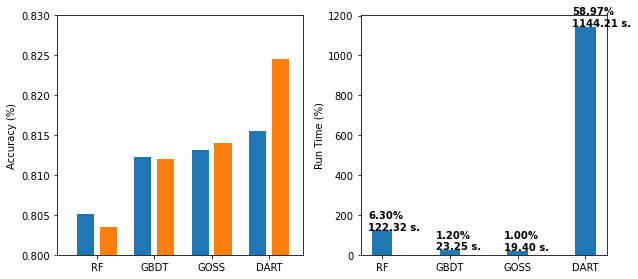

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

scores = np.array(list(cv_scores.values()))
ax[0].bar(np.arange(1, 5)-0.2, scores, width=0.3)
scores = np.array(list(tst_scores.values()))
ax[0].bar(np.arange(1, 5)+0.2, scores, width=0.3)
ax[0].axis([0.3, 4.6, 0.8, 0.83])
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_xticks([1, 2, 3, 4]);
ax[0].set_xticklabels(['RF', 'GBDT', 'GOSS', 'DART']);

times = np.array(list(run_time.values()))
times_scaled = times / np.min(times)
ax[1].bar(np.arange(1, 5), times, width=0.3)
for i, v in enumerate(times_scaled):
    ax[1].text(i + 0.8, times[i] + 3.5, '{0:3.2f}%\n{1:4.2f} s.'.format(v, times[i]), fontweight='bold')
ax[1].set_ylabel('Run Time (%)')
ax[1].set_xticks([1, 2, 3, 4]);
ax[1].set_xticklabels(['RF', 'GBDT', 'GOSS', 'DART']);

fig.tight_layout()
pngFile = './figures/CH05_F22_Kunapuli.png'
plt.savefig(pngFile, dpi=300, pad_inches=0)